## Context

Here, I will implement several neural network models to classify images from the [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10) database.

The Animals-10 database contains approximately 28,000 medium-quality animal images, divided into 10 categories, each stored in a separate folder. The number of images per category varies between 2,000 and 5,000.

Install and load relevant libraries

In [1]:
# Instalamos la última versión de Tensorflow (con CUDA)
%pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 94.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 69.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 63.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 17.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━

In [2]:
# Import Tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Available GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# Keras version
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.16.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Keras version   :  3.3.3


In [3]:
# Import Keras relevant elements
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input, 
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model

In [4]:
# Import other relevant libraries
import cv2
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns

## 1. Data loading and pre-processing

Images can be found in this [link](https://www.kaggle.com/datasets/svalbuenaa/images-deep-learning-cnns)

In [5]:
# Extract names of the clases
# For the train dataset
train_dir_path = "/kaggle/input/images-deep-learning-cnns/images/train"
train_classes = os.listdir(train_dir_path)
print(train_classes)

['spider', 'horse', 'butterfly', 'dog', 'chicken', 'elephant', 'sheep', 'cow', 'squirrel', 'cat']


In [6]:
# For the test dataset
test_dir_path = "/kaggle/input/images-deep-learning-cnns/images/test"
test_classes = os.listdir(test_dir_path)
print(test_classes)

['spider', 'horse', 'butterfly', 'dog', 'chicken', 'elephant', 'sheep', 'cow', 'squirrel', 'cat']


In [7]:
# Number of instances per class (train dataset)
train_instances = {}
for el in range(len(train_classes)):
    print(train_classes[el]+": "+str(len(os.listdir(train_dir_path+"/"+train_classes[el]))))
    train_instances.update({el:[train_classes[el],len(os.listdir(train_dir_path+"/"+train_classes[el]))]})

spider: 4098
horse: 2230
butterfly: 1795
dog: 4134
chicken: 2633
elephant: 1229
sheep: 1547
cow: 1586
squirrel: 1583
cat: 1418


In [8]:
# Number of instances per class (test dataset)
test_instances = {}
for el in range(len(test_classes)):
    print(test_classes[el]+": "+str(len(os.listdir(test_dir_path+"/"+test_classes[el]))))
    test_instances.update({el:[test_classes[el],len(os.listdir(test_dir_path+"/"+test_classes[el]))]})

spider: 723
horse: 393
butterfly: 317
dog: 729
chicken: 465
elephant: 217
sheep: 273
cow: 280
squirrel: 279
cat: 250


In [9]:
# Total number of instances in the training and test sets, proportion of instances in each set

total_instances_train = 0
total_instances_test = 0

for key in train_instances.keys():
    total_instances_train += train_instances[key][1]
    total_instances_test += test_instances[key][1]

print("Total number of instances in the dataset: "+str(total_instances_train+total_instances_test))
print("Total number of instances in the training set: "+str(total_instances_train))
print("Total number of instances in the test set: "+str(total_instances_test))
print("Percentage of instances in the training set: "+str(total_instances_train*100/(total_instances_train+total_instances_test)))
print("Percentage of instances in the test set: "+str(total_instances_test*100/(total_instances_train+total_instances_test)))

Total number of instances in the dataset: 26179
Total number of instances in the training set: 22253
Total number of instances in the test set: 3926
Percentage of instances in the training set: 85.00324687726804
Percentage of instances in the test set: 14.996753122731961


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'spider'),
  Text(1, 0, 'horse'),
  Text(2, 0, 'butterfly'),
  Text(3, 0, 'dog'),
  Text(4, 0, 'chicken'),
  Text(5, 0, 'elephant'),
  Text(6, 0, 'sheep'),
  Text(7, 0, 'cow'),
  Text(8, 0, 'squirrel'),
  Text(9, 0, 'cat')])

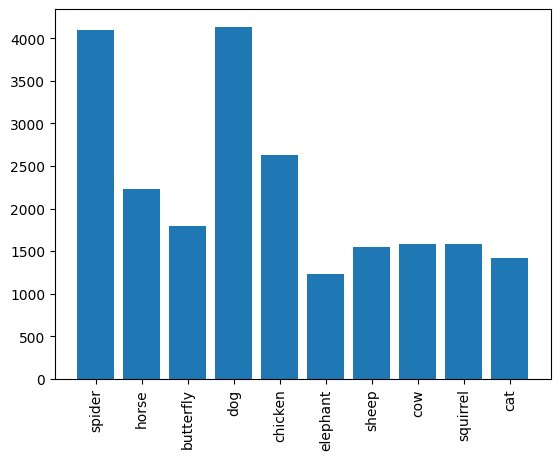

In [10]:
# Number of instances per class, barplot, training set
df_train = pd.DataFrame.from_dict(train_instances, orient='index', columns=["animal", "instances"])
plt.bar(x=df_train["animal"], height=df_train["instances"])
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'spider'),
  Text(1, 0, 'horse'),
  Text(2, 0, 'butterfly'),
  Text(3, 0, 'dog'),
  Text(4, 0, 'chicken'),
  Text(5, 0, 'elephant'),
  Text(6, 0, 'sheep'),
  Text(7, 0, 'cow'),
  Text(8, 0, 'squirrel'),
  Text(9, 0, 'cat')])

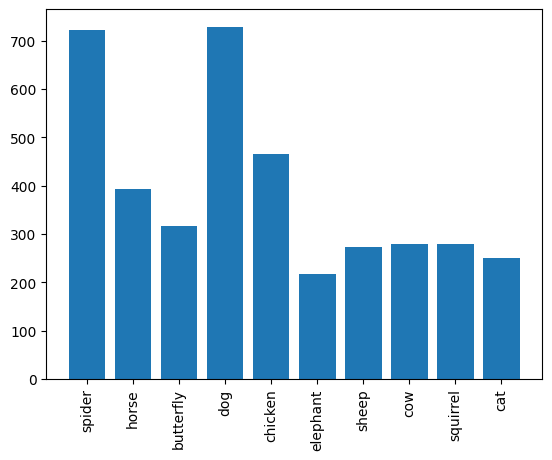

In [11]:
# Number of instances per class, barplot, test set
df_test = pd.DataFrame.from_dict(test_instances, orient='index', columns=["animal", "instances"])
plt.bar(x=df_test["animal"], height=df_test["instances"])
plt.xticks(rotation=90)

We have the same 10 classes for both the training and test sets. As we have seen, the classes are as follows: butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, and squirrel.<br> 

The dataset contains 26,179 instances, of which 85% belong to the training set and the remaining 15% to the test set.<br> 

Looking at the bar chart, we can see that the data is balanced between the training and test sets. In both sets, the most represented class is dog, followed by spider. Conversely, the least represented class is elephant, followed by cat. For all other classes, the proportions are also very similar in both sets.

To put numbers to the previous statement, we can take some examples. In the case of the dog class, the most represented, there are 4,134 instances in the training set and 729 in the test set. Considering that there are 22,253 instances in the training set, the dog instances make up 18.58% of that set. In the test set, there are 3,926 instances, so dog instances constitute 18.57% of that set. A similar example is the butterfly class. In the training set, there are 1,795 instances of this class (8.07% of the set), while in the test set, there are 317 instances (also 8.07% of the set). The same applies to all other classes.<br>

To conclude this section, we must consider the balance between the different classes. Here, significant differences do exist. For example, in contrast to the dog class, which accounts for more than 18% of the instances in each set, the elephant class drops to 5.52%. While these differences are not as stark as those found in other types of datasets (e.g., credit card fraud datasets), it is possible that the networks we train may be affected by this imbalance—perhaps more so in the fully connected layers than in the convolutional layers. When reviewing the results, I will try to keep this possibility in mind.

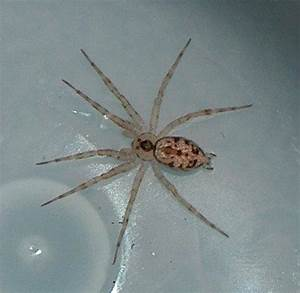

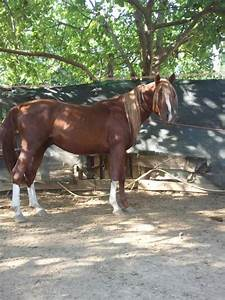

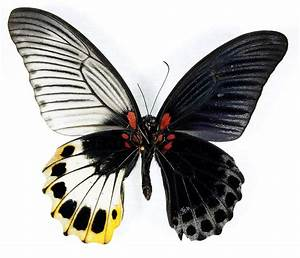

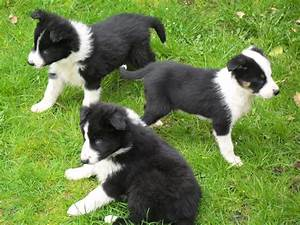

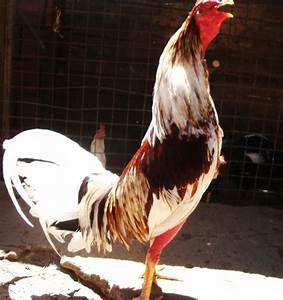

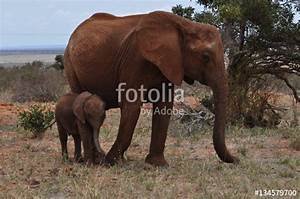

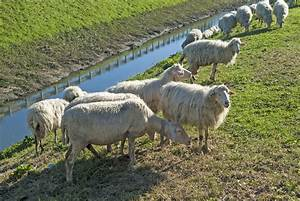

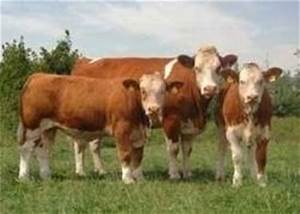

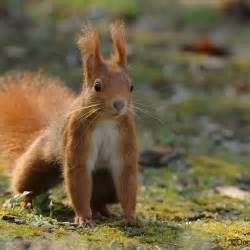

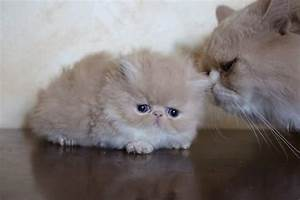

In [12]:
# Visualizing one image per class
for el in range(len(train_classes)):
    img = Image.open(train_dir_path+"/"+train_classes[el]+"/"+os.listdir(train_dir_path+"/"+train_classes[el])[0])
    display(img)
    print("\n")

In [13]:
# Calculate dynamic range and image sizes 
for el in range(len(train_classes)):
    img = Image.open(train_dir_path+"/"+train_classes[el]+"/"+os.listdir(train_dir_path+"/"+train_classes[el])[0])
    print("Image corresponding to class: "+train_classes[el])
    print("Image size (width, heigth): "+str(img.size))
    print("Dynamic range (R,G,B): "+str(img.getextrema()))
    print("\n")

Image corresponding to class: spider
Image size (width, heigth): (300, 293)
Dynamic range (R,G,B): ((7, 249), (0, 255), (0, 255))


Image corresponding to class: horse
Image size (width, heigth): (225, 300)
Dynamic range (R,G,B): ((0, 255), (0, 255), (0, 255))


Image corresponding to class: butterfly
Image size (width, heigth): (300, 258)
Dynamic range (R,G,B): ((0, 255), (0, 255), (0, 255))


Image corresponding to class: dog
Image size (width, heigth): (300, 225)
Dynamic range (R,G,B): ((0, 255), (0, 255), (0, 255))


Image corresponding to class: chicken
Image size (width, heigth): (283, 300)
Dynamic range (R,G,B): ((0, 255), (0, 255), (0, 255))


Image corresponding to class: elephant
Image size (width, heigth): (300, 199)
Dynamic range (R,G,B): ((0, 255), (0, 255), (0, 255))


Image corresponding to class: sheep
Image size (width, heigth): (300, 201)
Dynamic range (R,G,B): ((0, 255), (0, 255), (0, 255))


Image corresponding to class: cow
Image size (width, heigth): (300, 214)
Dy

An image from each class has been displayed to check whether they have the same dimensions. Additionally, for one image per class, the number of pixels in height and width as well as the dynamic range of each of the three channels (R, G, B) has been shown.<br>
Although the images (at least the examples shown) do not differ much in size, we can see that they do not share the same dimensions. This is something we will need to standardize to work with them in the networks.<br>

In terms of dynamic range, we see that the images are at 8-bit depth (i.e., each channel has values ranging from 0 to 255). However, the dynamic range values are not the same across all images for each channel, which is somewhat expected since each image was likely captured under different lighting conditions.<br>

In both cases—image size and dynamic range—we must take specific actions to prepare the images for input into the networks we create. Regarding size, we need to resize the images to a consistent pixel scale (as detailed below, the new scale will be 299x299 pixels). This will ensure that the convolutional filters function properly and can be applied uniformly across all images. For dynamic range, it is important to rescale the illumination values to the range (0, 1), which is suitable for neural networks. This range aligns with the activation functions of the neurons and helps prevent learning imbalances. If one channel has significantly brighter pixels than others, rescaling avoids skewing the learning process toward that channel.

### 1.1. Adapting images formating to Keras/Tensorflow

To create a database in the Keras/TensorFlow format using the provided images, we will use the function <code>tf.keras.utils.image_dataset_from_directory()</code> as it allows us to generate datasets from images stored in folders.

The documentation for this function can be found on both the [Keras website](https://keras.io/api/data_loading/image/) and the [TensorFlow website](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

The goal is to create three datasets: train, validation, and test.

Additionally, we will resize the images to 299x299, which is the size used to train the InceptionV3 network that we will use in a later section.

Using the <code>image_dataset_from_directory()</code> function, I will generate three datasets from the analyzed folders. The images will be resized to 299x299 pixels in RGB format (299,299,3) and grouped into batches of size 64 (batch=64) while maintaining their dynamic range. 

In [14]:
# Training set
batch_size = 64
image_size = (299, 299)
validation_split = 0.1764

# Establish a seed for replicability
seed = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_path,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset="training",
    seed=seed)

Found 22253 files belonging to 10 classes.
Using 18328 files for training.


In [15]:
# Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_path,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset="validation",
    seed=seed)

Found 22253 files belonging to 10 classes.
Using 3925 files for validation.


In [16]:
# Test set

# For the test dataset, we set shuffle=False to facilitate the extraction of labels in the correct order, ensuring that the confusion matrices are accurate.
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_path,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
    seed=seed)

Found 3926 files belonging to 10 classes.


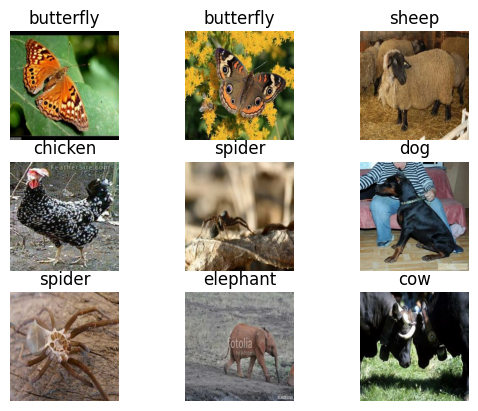

In [17]:
# Visualization of some images

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [18]:
# One hot encoding
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, 10)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, 10)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, 10)))

We have split the data into training, validation, and test sets. A seed was used to ensure replicability.
From the original dataset (26,179 images), the training subset now contains 18,328 instances (70% of the total). The validation subset contains 3,925 instances (15% of the total), and the test subset contains 3,926 instances (15% of the total).

Finally, one-hot encoding was applied to the class labels so that these labels can be passed to the neural networks we will generate.

## 2. ANN model

In this section, we are going to train and evaluate a very simple fully connected model to establish a baseline result.

Since inputs in an artificial neural network are one-dimensional, the first thing we need to do is reshape the input data (the images) to convert them into one-dimensional arrays.

Working with 299x299-sized images in a fully connected network would require training an excessively large number of parameters. Therefore, we will define a model that resizes the input images to 32x32 beforehand and flattens the pixels to create a one-dimensional vector of size 3072 (32x32x3).

Subsequently, we will train a classifier (a fully connected network) to carry out the classification of our data.

In this section, we will use the following Keras layers: [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/), and [Dropout](https://keras.io/api/layers/regularization_layers/dropout/).

The network will have the following architecture:

1. A layer that reduces the input dimensions from (299, 299) to (32, 32).
2. A rescaling layer to ensure that the image values are between 0 and 1.
3. A Flatten layer to convert the image into a vector of 3072 positions.
4. A fully connected layer with 2048 neurons and ReLU activation.
5. A Dropout layer (with a probability of 0.5).
6. A fully connected layer with 1024 neurons and ReLU activation.
7. A Dropout layer (with a probability of 0.5).
8. A fully connected output layer for the final classification, where the number of neurons should be equal to the number of classes in the dataset, and with the appropriate activation function for classification tasks.

In [19]:
# Network definition
img_inputs = keras.Input(shape=(299, 299, 3))
img_resizing = keras.layers.Resizing(32, 32)(img_inputs)
img_rescaling = keras.layers.Rescaling(scale=1./255)(img_resizing)
img_flatten = keras.layers.Flatten()(img_rescaling)
dense_1 = keras.layers.Dense(2048, activation="relu")(img_flatten)
dropout_1 = keras.layers.Dropout(rate = 0.5)(dense_1)
dense_2 = keras.layers.Dense(1024, activation="relu")(dropout_1)
dropout_2 = keras.layers.Dropout(rate = 0.5)(dense_2)

#Check if the correct function is softmax
output = keras.layers.Dense(10, activation="softmax")(dropout_2)

model_FC = Model(inputs = img_inputs, outputs = output)

In [20]:
# Compiling
model_FC.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_FC.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401,930 (32.05 MB)

 Trainable params: 8,401,930 (32.05 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_FC = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

history_FC = model_FC.fit(
    x=train_ds,
    epochs=100,
    callbacks = early_stopping_FC,
    validation_data = val_ds)
print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100


I0000 00:00:1733294206.594805     126 service.cc:145] XLA service 0x78fb14003bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733294206.594846     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733294206.594850     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  9/287 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1459 - loss: 2.6572

I0000 00:00:1733294214.141155     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


287/287 ━━━━━━━━━━━━━━━━━━━━ 58s 173ms/step - accuracy: 0.1869 - loss: 2.3154 - val_accuracy: 0.2390 - val_loss: 2.0850
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.2488 - loss: 2.1099 - val_accuracy: 0.2831 - val_loss: 2.0121
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.2731 - loss: 2.0340 - val_accuracy: 0.3152 - val_loss: 1.9571
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.2959 - loss: 1.9857 - val_accuracy: 0.3269 - val_loss: 1.9293
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.3069 - loss: 1.9559 - val_accuracy: 0.3322 - val_loss: 1.9127
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.3226 - loss: 1.9204 - val_accuracy: 0.3501 - val_loss: 1.8857
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.3268 - loss: 1.9074 - val_accuracy: 0.3460 - val_loss: 1.8700
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.3344 - loss: 1.8873 - val

In [22]:
# Function to show loss and accuracy
def loss_acc_plot(history, title=""):
    fig, ax = plt.subplots(1,2)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='upper right')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Test'], loc='upper right')
    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.02)
    plt.show()

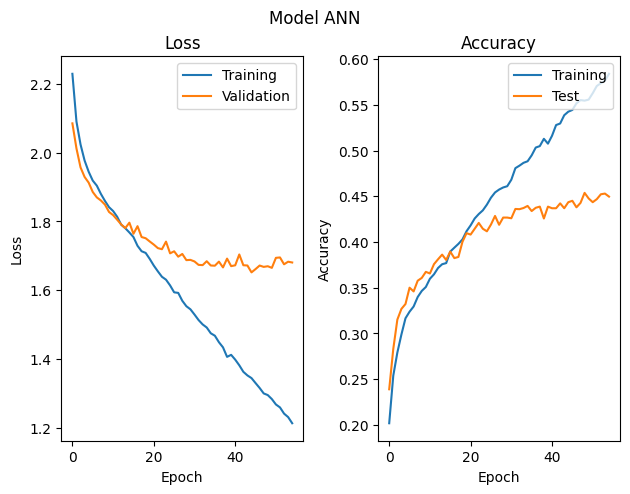

In [23]:
# Training loss and accuracy
loss_acc_plot(history_FC, "Model ANN")

In [24]:
# Model evaluation
predict_FC = model_FC.predict(
    test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step


In [25]:
# Format the predicted and true labels to obtain the confusion matrix and accuracy
predicted_labels_FC = np.argmax(predict_FC, axis=1)

true_labels_FC = []
for images, labels in test_ds:
    true_labels_FC.extend(labels.numpy())

true_labels_FC = np.argmax(true_labels_FC, axis=1)

In [26]:
# Get the confusion matrix
conf_matrix_FC = confusion_matrix(true_labels_FC, predicted_labels_FC)
conf_matrix_FC

array([[ 85,  11,  27,   6,  52,   2,   5,  13,  94,  22],
       [  9,  32,  20,   2, 107,   3,   4,   6,  41,  26],
       [ 23,   9, 196,  14,  56,   5,  18,  26,  77,  41],
       [  2,   2,  23, 120,  34,  11,  44,  18,  14,  12],
       [ 21,  37,  60,  30, 331,  17,  34,  39, 109,  51],
       [  4,   5,  11,   9,  32,  52,  31,   5,  47,  21],
       [  5,   1,  19,  42,  37,  26, 203,  24,  27,   9],
       [ 10,   4,  29,  45,  49,  11,  11,  60,  35,  19],
       [ 37,  28,  27,  11,  60,   6,  13,  17, 478,  46],
       [ 12,   8,  31,   5,  52,   4,   7,   7,  78,  75]])

In [27]:
# Calculate the metrics
metrics_model_FC = model_FC.evaluate(test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3504 - loss: 1.9478


Let´s begin with the analysis of the results generated by the ANN model. This network is fully connected and does not contain convolutional layers.

1.- Number of neurons recommended for the intermediate layers:
The number of neurons in the intermediate layers is somewhat arbitrary and is often determined empirically. Very high numbers of neurons in the intermediate layers can lead to overfitting, while very low numbers can be associated with poorer metrics. As a guideline, an appropriate number might be between two and three times the number of neurons in the input layer. In this case, after resizing and rescaling, our images are converted into vectors of 3072 positions (i.e., 32x32x3). Therefore, we can consider that the "effective" input to the network is this layer that generates the 3072-position vectors. Based on this value , we could expect the intermediate layers to have a number of neurons between two and three times this value. However, here we did not follow this *theoretical* recommendation because we only have 2048 neurons in the first Dense layer and 1024 in the second, so we are far from the 6000-9000 neurons we might expect for an input like the one generated by the Flatten layer.

2.- Number of parameters to train and training time:
The number of parameters to train is 8,401,930 (i.e., all the model parameters). The training time is about 30-40 seconds per epoch, so the total training time was about 25 minutes. It is important to note that during training, the callback we set up to stop the training if the validation loss stopped decreasing was triggered, so the 100 epochs we set in the code were not reached.

3.- General comments of the loss and accuracy plots:
We have a fairly poor result using the fully-connected network without convolutional layers. The problem with this type of network is that they are not designed to work with images, and therefore we cannot expect particularly good metrics. The idea behind convolutional networks is to extract increasingly complex "features" that later allow the identification of the image (or segmentation of parts of the image). Without kernels to detect these features, fully-connected networks like this one are less optimal for detecting shapes that help identify the classes. That’s why we get accuracy values around 50-60% even for the training set. For the validation set, we see the accuracy is around 45%, and for the test set, it is below 40%. It’s interesting to highlight that for the validation set, the loss curve reaches an asymptote with accuracy values significantly lower than those of the training set. It is possible that the model is overfitting. One last note regarding the graphs is that, as seen in this one and others, the loss and accuracy curves for the training set are "smoother" than for the validation set, probably due to the smaller number of samples in the latter.

## 3. Small CNN

Given the poor performance of the previous model, we will try a different type of network to achieve better results in the classification task we need to perform.

Convolutional Neural Networks (CNNs) are particularly well-suited for modeling data where patterns exist in two dimensions, such as images.

In the classification task, the structure of a CNN is divided into two main blocks:

Feature extraction block: This block generates different levels of abstraction of the input image through convolutional layers. The deeper these layers are, the more prepared they are for the classification task.
Classifier: This block consists of fully connected layers, and its output is the probability associated with each class.
In the previous section, the "feature extraction" block was extremely simple, if not non-existent. In this section, we will use convolutional layers to learn better abstractions of the input images to improve their classification.

Here, we will use the following Keras layers: [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/).

The network will have the following architecture:

A feature extraction block consisting of:
1.- Input Layer: An input layer with dimensions appropriate for the data.
2.- Rescaling Layer: A rescaling layer to normalize image values between 0 and 1.
3.- 3 Convolutional Layers. Each with a kernel size of 3x3, using 'same' padding and ReLU activation. The number of filters for each convolutional layer is 16, 32, and 64, respectively.
4.- MaxPooling2D Layer: A Max Pooling2D layer follows each convolutional layer.
5.- Dropout Layer: A dropout layer with a probability of 0.2.

The final classifier follows the structure of the model from the previous section:
1.- Flatten Layer: A flatten layer to transform multidimensional data into a single vector.
2.- Fully Connected Layer: A fully connected layer with 64 neurons and ReLU activation.
3.- Dropout Layer: A dropout layer with a probability of 0.5.
4.- Output Layer: A fully connected output layer with a number of neurons equal to the number of classes in the dataset and an appropriate activation function for the classification task.



In [28]:
# Network definition
model_CNN_small = keras.Sequential()

# Feature extractor
model_CNN_small.add(Input(shape=(299, 299, 3)))
model_CNN_small.add(Rescaling(scale=1./255))
model_CNN_small.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model_CNN_small.add(MaxPooling2D())
model_CNN_small.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model_CNN_small.add(MaxPooling2D())
model_CNN_small.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model_CNN_small.add(MaxPooling2D())
model_CNN_small.add(Dropout(rate = 0.2))
                    
# Classificator
model_CNN_small.add(Flatten())
model_CNN_small.add(Dense(64, activation="relu"))
model_CNN_small.add(Dropout(rate = 0.5))
model_CNN_small.add(Dense(10, activation="softmax"))

In [29]:
# Compiling
model_CNN_small.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_CNN_small.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,722 (21.48 MB)

 Trainable params: 5,631,722 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_CNN_small = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for ReduceLROnPlateau
ReduceLROnPlateau_CNN_small = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_delta=1e-6
)

history_CNN_small = model_CNN_small.fit(
    x=train_ds,
    epochs=100,
    callbacks = [early_stopping_CNN_small, ReduceLROnPlateau_CNN_small],
    validation_data = val_ds)

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.1935 - loss: 2.2200 - val_accuracy: 0.2825 - val_loss: 2.0146 - learning_rate: 1.0000e-04
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.2605 - loss: 2.0576 - val_accuracy: 0.3396 - val_loss: 1.9484 - learning_rate: 1.0000e-04
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.2860 - loss: 1.9779 - val_accuracy: 0.3758 - val_loss: 1.8649 - learning_rate: 1.0000e-04
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.3039 - loss: 1.9221 - val_accuracy: 0.3829 - val_loss: 1.8232 - learning_rate: 1.0000e-04
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.3248 - loss: 1.8681 - val_accuracy: 0.4082 - val_loss: 1.7655 - learning_rate: 1.0000e-04
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.3486 - loss: 1.8178 - val_accuracy: 0.4433 - val_loss: 1.7050 - learning_rate: 1.0000e-04
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 25s 

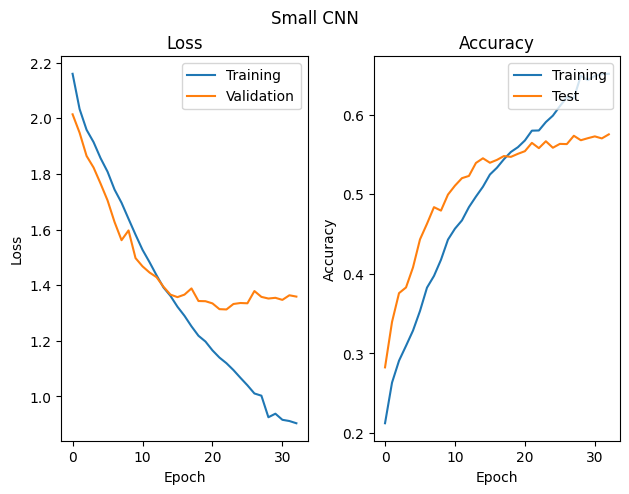

In [31]:
# Training loss and accuracy
loss_acc_plot(history_CNN_small, "Small CNN")

In [32]:
# Model evaluation
predict_CNN_small = model_CNN_small.predict(
    test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step


In [33]:
# Format the predicted and actual labels to calculate the confusion matrix and accuracy.
predicted_labels_CNN_small = np.argmax(predict_CNN_small, axis=1)

true_labels_CNN_small = []
for images, labels in test_ds:
    true_labels_CNN_small.extend(labels.numpy())

true_labels_CNN_small = np.argmax(true_labels_CNN_small, axis=1)

In [34]:
# Get the confusion matrix
conf_matrix_CNN_small = confusion_matrix(true_labels_CNN_small, predicted_labels_CNN_small)
conf_matrix_CNN_small

array([[223,   0,   5,   3,   6,   0,   1,   0,  76,   3],
       [  6,  35,   4,   1, 120,   3,   3,   3,  66,   9],
       [ 29,   3, 281,   3,  80,   0,   8,  14,  35,  12],
       [  1,   0,  23, 130,  51,   8,  33,  22,  10,   2],
       [  9,  17,  39,  26, 512,  13,  35,  16,  50,  12],
       [  9,   2,  17,  27,  27,  75,  24,  18,  15,   3],
       [  7,   0,  12,  42,  66,  14, 232,   9,   9,   2],
       [  8,   5,  35,  32,  42,   6,  13, 111,  17,   4],
       [124,  10,  25,   5,  32,   1,   4,   6, 508,   8],
       [ 11,   5,  48,   3,  74,   0,   4,   8,  45,  81]])

In [35]:
# Calcute and show the metrics
metrics_model_CNN_small = model_CNN_small.evaluate(test_ds)

print("Loss for the test set: "+str(metrics_model_CNN_small[0]))
print("Accuracy for the test set: "+str(metrics_model_CNN_small[1]))

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5582 - loss: 1.3337
Loss for the test set: 1.3954081535339355
Accuracy for the test set: 0.5573102235794067


Moving on to the analysis of the results generated by the small CNN model
This network consists of three convolutional layers and two fully connected layers.

1. Number of parameters to train and the training time: The number of parameters to train in this case is 5,631,722. The training time is approximately 35-40 seconds per epoch. The callback we implemented triggers when the loss on the test set stops decreasing, so the total training time is around 18 minutes.

2. Accuracy is achieved: There is a significant increase in accuracy in this case. Even though the values are relatively low for all datasets, it is important to note that with nearly three million fewer parameters and less training time, we can generate a network with higher accuracy values:</br>
**Training set**: 76% accuracy</br>
**Validation set**: 61% accuracy</br>
**Test set**: 57% accuracy</br>
This improvement is due to the use of convolutional layers, even if there are only three. These layers, placed before the fully connected layers, improve the network's performance by acting as feature extractors. Unlike the network without convolutional layers, this setup generates intermediate outputs that help the final fully connected layers determine the class of each image more effectively.</br>

3. Training curve graphs: The training and validation curves still show an asymptote in loss and accuracy for the validation set, suggesting that this model may also suffer from overfitting. Overfitting could occur for several reasons:</br>
**Excessive network depth**: This is unlikely, as the network is not overly deep.</br>
**Data imbalance**: Although data imbalance can cause overfitting, this dataset does not seem to suffer significantly from this issue.</br>
**Lack of regularization layers**: Regularization layers, such as dropout, help reduce overfitting by affecting connection weights (e.g., setting random weights to 0 or reducing large weights). Both the ANN and small CNN include two regularization layers.</br>
**Small training dataset**: A small training dataset can also lead to overfitting. Thus, one way to mitigate overfitting, as we will explore next, is to increase the amount of data.







## 4. Data augmentation

One way to partially solve the problem we encountered in the previous section is to train the model with a larger amount of data.

Since we do not have more data available (as we use all the images from the training set in each epoch), one way to increase the number of instances is to apply some type of augmentation technique.

To this end, Keras offers several layers, such as RandomFlip, RandomRotation, RandomZoom, and more.

Now, we will implement augmentation of the data with:

1. A RandomFlip layer that flips the images horizontally only
2. A RandomRotation layer with a factor of 0.1

In [36]:
# Augmentation model
model_augm = keras.Sequential()
model_augm.add(RandomFlip(mode="horizontal"))
model_augm.add(RandomRotation(factor=0.1))

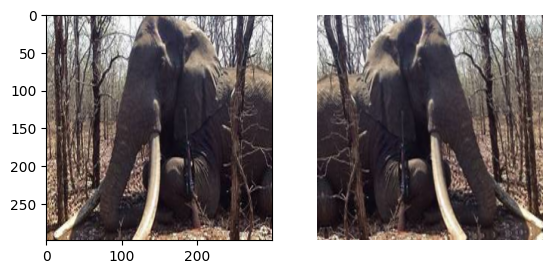

In [37]:
# Displaying augmented data
for images, labels in train_ds.take(1):
    image = images[0]  # Retrieve the first image from the batch
    image_augm = model_augm(image)
    # Display the image using matplotlib
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image.numpy().astype("uint8"))
    ax[1].imshow(image_augm.numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

With the extra data created, training should result in less overfitting and a better generalization. Let´s implement these layers in the model:

In [38]:
# Network definition
model_CNN_small_augm = keras.Sequential()

# Feature extractor
model_CNN_small_augm.add(Input(shape=(299, 299, 3)))
model_CNN_small_augm.add(Rescaling(scale=1./255))
model_CNN_small_augm.add(RandomFlip(mode="horizontal"))
model_CNN_small_augm.add(RandomRotation(factor=0.1))
model_CNN_small_augm.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model_CNN_small_augm.add(MaxPooling2D())
model_CNN_small_augm.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model_CNN_small_augm.add(MaxPooling2D())
model_CNN_small_augm.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model_CNN_small_augm.add(MaxPooling2D())
model_CNN_small_augm.add(Dropout(rate = 0.2))

# Classificator
model_CNN_small_augm.add(Flatten())
model_CNN_small_augm.add(Dense(64, activation="relu"))
model_CNN_small_augm.add(Dropout(rate = 0.5))
model_CNN_small_augm.add(Dense(10, activation="softmax"))

In [39]:
# Compiling
model_CNN_small_augm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_CNN_small_augm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 299, 299, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 149, 149, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,722 (21.48 MB)

 Trainable params: 5,631,722 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_CNN_small_augm = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for ReduceLROnPlateau
ReduceLROnPlateau_CNN_small_augm = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_delta=1e-6
)

history_CNN_small_augm = model_CNN_small_augm.fit(
    x=train_ds,
    epochs=100,
    callbacks = [early_stopping_CNN_small_augm, ReduceLROnPlateau_CNN_small_augm],
    validation_data = val_ds)
print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100


2024-12-04 07:07:20.108535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


287/287 ━━━━━━━━━━━━━━━━━━━━ 49s 153ms/step - accuracy: 0.1751 - loss: 2.3419 - val_accuracy: 0.2558 - val_loss: 2.0572 - learning_rate: 0.0010
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.2606 - loss: 2.0864 - val_accuracy: 0.3185 - val_loss: 1.9394 - learning_rate: 0.0010
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - accuracy: 0.2924 - loss: 1.9940 - val_accuracy: 0.3315 - val_loss: 1.8691 - learning_rate: 0.0010
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.3115 - loss: 1.9228 - val_accuracy: 0.3442 - val_loss: 1.8689 - learning_rate: 0.0010
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.3305 - loss: 1.8756 - val_accuracy: 0.4110 - val_loss: 1.7362 - learning_rate: 0.0010
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.3679 - loss: 1.8152 - val_accuracy: 0.4273 - val_loss: 1.7154 - learning_rate: 0.0010
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.3766 -

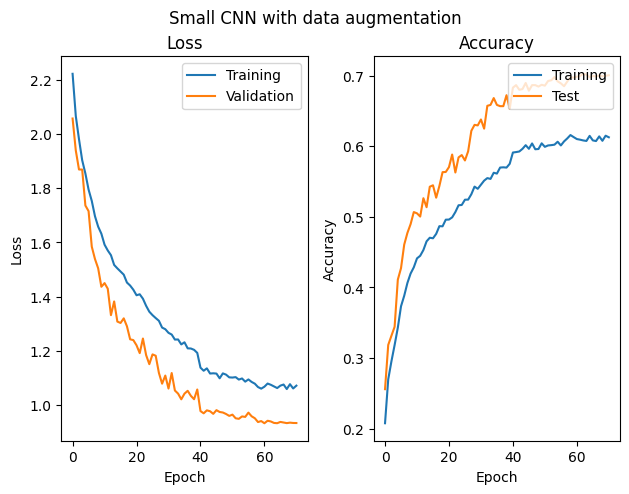

In [41]:
# Training loss and accuracy
loss_acc_plot(history_CNN_small_augm, "Small CNN with data augmentation")

In [42]:
# Model evaluation
predict_CNN_small_augm = model_CNN_small_augm.predict(
    test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


In [43]:
# Format the predicted and actual labels to calculate the confusion matrix and accuracy
predicted_labels_CNN_small_augm = np.argmax(predict_CNN_small_augm, axis=1)

true_labels_CNN_small_augm = []
for images, labels in test_ds:
    true_labels_CNN_small_augm.extend(labels.numpy())

true_labels_CNN_small_augm = np.argmax(true_labels_CNN_small_augm, axis=1)

In [44]:
# Get the confusion matrix
conf_matrix_CNN_small_augm = confusion_matrix(true_labels_CNN_small_augm, predicted_labels_CNN_small_augm)
conf_matrix_CNN_small_augm

array([[289,   1,   0,   1,   6,   0,   2,   0,  15,   3],
       [  3,  99,   2,   0, 111,   1,   1,   5,  20,   8],
       [  5,   0, 403,   2,  31,   2,   6,   7,   7,   2],
       [  0,   0,  10, 113,  37,  16,  59,  40,   3,   2],
       [  4,  24,  22,   6, 586,  19,  36,  15,  11,   6],
       [ 12,   4,   4,   3,  35, 132,  10,  13,   0,   4],
       [  1,   0,  11,  46,  44,  20, 260,   7,   2,   2],
       [  1,   5,  10,  20,  92,  20,   9,  99,   3,  14],
       [124,  18,  12,   0,  29,   2,   5,   4, 520,   9],
       [  4,   5,  37,   0,  48,   3,   5,   8,  21, 148]])

In [45]:
# Calculate and display the metrics
metrics_model_CNN_small_augm = model_CNN_small_augm.evaluate(test_ds)

print("Loss for the test set: "+str(metrics_model_CNN_small_augm[0]))
print("Accuracy for the test set: "+str(metrics_model_CNN_small_augm[1]))

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7259 - loss: 0.8512
Loss for the test set: 1.0589090585708618
Accuracy for the test set: 0.6747325658798218


Moving on to analyzing the results generated by the small CNN model with data augmentation. This network has two data augmentation layers, three convolutional layers, and two fully connected layers.
Response to the questions posed in the problem statement:

1. Number of parameters and the training time: The data augmentation layers we added do not need to learn anything; they simply act on the input data to augment it. Therefore, the number of parameters remains the same as for the small CNN network without data augmentation, i.e., 5,631,722. However, introducing data augmentation layers increases the time per epoch to over 50 seconds (because rotation and flipping processes require computation time), which raises the total training time to about 74 minutes.

2. Accuracy achieved with this model: Before answering this question, let's consider what we're doing by introducing data augmentation layers. In each epoch, the data augmentation layers may (or may not) rotate or flip each image. Therefore, for practical purposes, it’s as if we had many more images (by adding rotations or flips of the existing images) in the dataset. Consequently, it’s expected that accuracy improves.
However, what we observe with this network is notable. We see that the training set accuracy is significantly lower than the validation set accuracy. The training set accuracy is lower than that of the small CNN without augmentation (54%), indicating that our goal of reducing overfitting might have worked. For the validation set, the accuracy at the end of training is 64%. Finally, for the test set, the accuracy is 63%.

3. Training graphs: By introducing data augmentation, we have been able to mitigate overfitting, which is reflected in the fact that the loss and accuracy no longer stabilize for the validation set while they continue evolving for the training set. Now, stabilization occurs simultaneously for both sets. As we can see (and in line with the accuracy data), the validation set loss line always lies below the training set loss line, and the opposite occurs for the accuracy line.
We can question why there is such a marked difference in terms of accuracy as observed earlier. It is possible that the reduction in overfitting due to data augmentation has caused the model's training accuracy to decrease while improving generalization. Additionally, dropout layers only regularize during training and do not act on the test set. Thus (and in line with a similar question on Stack Overflow, [here](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)), I believe that dropout might be further reducing the training set accuracy.

## 5. InceptionV3 and transfer learning 

Deep convolutional neural networks provide us with the ability to enhance a model's learning capacity. Some common architectures can include hundreds of convolutional layers. However, training these architectures from scratch can be costly in terms of both time and resources, and it also requires fairly large datasets.

In this section, we will apply [transfer learning](https://keras.io/guides/transfer_learning/) to save part of the training effort. This methodology involves leveraging the weights of a model trained on another dataset and for a different task. Specifically, we will use the [InceptionV3](https://keras.io/api/applications/inceptionv3/) model pretrained on [Imagenet](http://www.image-net.org/) and adapt it to classify the 10 categories of our dataset.

In the Keras version of InceptionV3, there is an option to load the weights trained on Imagenet without the fully connected layers at the end of the network (using the parameter <code>include_top = False</code>). We will replace those layers and retrain the model while keeping the rest of the weights frozen.

Since the number of parameters being utilized is significantly larger, it is a good idea to perform deeper data augmentation. This will be the architecture of the daa augmentation part of the network:

1. A RandomFlip layer that flips images horizontally only.
2. A RandomRotation layer with a factor of 0.1.
3. A RandomZoom layer with a factor of 0.1.
4. A RandomContrast layer with a factor of 0.1.

Let's see the effect of performing these modifications on an image:

In [46]:
model_augm_InV3 = keras.Sequential()
model_augm_InV3.add(RandomFlip(mode="horizontal"))
model_augm_InV3.add(RandomRotation(factor=0.1))
model_augm_InV3.add(RandomZoom(height_factor=0.1))
model_augm_InV3.add(RandomContrast(factor=0.1))

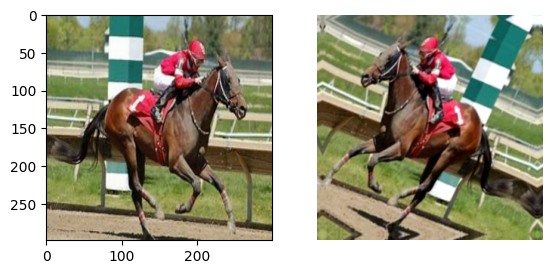

In [47]:
for images, labels in train_ds.take(1):
    image = images[0]  # Retrieve the first image from the batch
    image_augm = model_augm_InV3(image)
    # Display the image using matplotlib
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image.numpy().astype("uint8"))
    ax[1].imshow(image_augm.numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

To properly reuse the model, it is necessary to preprocess the data in the same way as was done during training on the original dataset. Keras makes it easy to apply normalization for pretrained models. In the case of InceptionV3, this normalization is performed by adding keras.applications.inception_v3.preprocess_input between the inputs and the model.

The inception_v3.preprocess_input function will scale the input pixels to a range between -1 and 1 (note that this function should be applied to images with a dynamic range of 0 to 255).

In [48]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# Load the model
base_inception = InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [49]:
# Freeze the weights
base_inception.trainable = False

In [50]:
# Network definition
inception_augm_input = Input(shape=(299, 299, 3))
inception_augm_RF = RandomFlip(mode="horizontal")(inception_augm_input)
inception_augm_RR = RandomRotation(factor=0.1)(inception_augm_RF)
inception_augm_RZ = RandomZoom(height_factor=0.1)(inception_augm_RR)
inception_augm_RC = RandomContrast(factor=0.1)(inception_augm_RZ)
inception_augm_preprocess_input = preprocess_input(inception_augm_RC)
inception_augm_inception = base_inception(inception_augm_preprocess_input)
inception_augm_GAP = GlobalAveragePooling2D()(inception_augm_inception)
inception_augm_dense_1 = Dense(1024, activation="relu")(inception_augm_GAP)
inception_augm_dense_2 = Dense(10, activation="softmax")(inception_augm_dense_1)

inception_augm = Model(inputs=inception_augm_input, outputs=inception_augm_dense_2)

In [51]:
# Compiling
inception_augm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
inception_augm.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 299, 299, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 299, 299, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,911,210 (91.21 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [52]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_inception_augm = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for ReduceLROnPlateau
ReduceLROnPlateau_inception_augm = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_delta=1e-6
)

history_inception_augm = inception_augm.fit(
    x=train_ds,
    epochs=100,
    callbacks = [early_stopping_inception_augm, ReduceLROnPlateau_inception_augm],
    validation_data = val_ds)
print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 117s 368ms/step - accuracy: 0.8477 - loss: 0.6226 - val_accuracy: 0.9715 - val_loss: 0.1082 - learning_rate: 1.0000e-04
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 98s 340ms/step - accuracy: 0.9587 - loss: 0.1416 - val_accuracy: 0.9722 - val_loss: 0.1012 - learning_rate: 1.0000e-04
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 98s 341ms/step - accuracy: 0.9627 - loss: 0.1215 - val_accuracy: 0.9707 - val_loss: 0.1029 - learning_rate: 1.0000e-04
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 98s 341ms/step - accuracy: 0.9624 - loss: 0.1193 - val_accuracy: 0.9755 - val_loss: 0.0899 - learning_rate: 1.0000e-04
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 98s 340ms/step - accuracy: 0.9694 - loss: 0.1018 - val_accuracy: 0.9750 - val_loss: 0.0924 - learning_rate: 1.0000e-04
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 98s 341ms/step - accuracy: 0.9716 - loss: 0.0932 - val_accuracy: 0.9766 - val_loss: 0.0867 - learning_rate: 1.0000e-04
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━

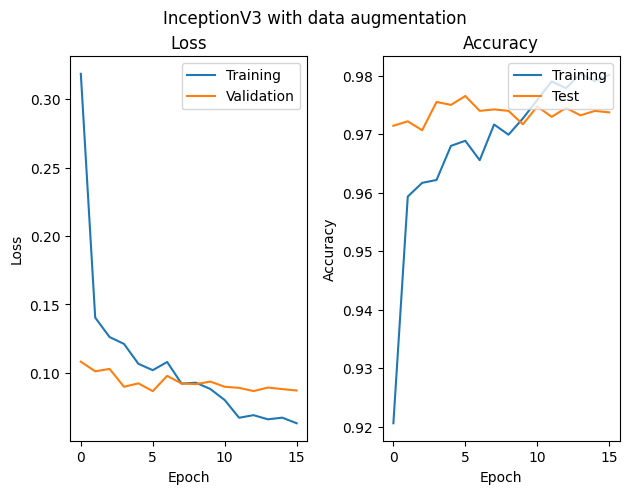

In [53]:
loss_acc_plot(history_inception_augm, "InceptionV3 with data augmentation")

In [54]:
# Model evaluation
predict_inception_augm = inception_augm.predict(
    test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 334ms/step


In [55]:
predicted_labels_inception_augm = np.argmax(predict_inception_augm, axis=1)

true_labels_inception_augm = []
for images, labels in test_ds:
    true_labels_inception_augm.extend(labels.numpy())

true_labels_inception_augm = np.argmax(true_labels_inception_augm, axis=1)

In [57]:
# Confusion matrix
conf_matrix_inception_augm = confusion_matrix(true_labels_inception_augm, predicted_labels_inception_augm)
conf_matrix_inception_augm

array([[316,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0, 246,   0,   0,   4,   0,   0,   0,   0,   0],
       [  0,   0, 464,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0, 270,   2,   1,   4,   3,   0,   0],
       [  0,   2,   2,   1, 723,   0,   0,   1,   0,   0],
       [  0,   0,   0,   1,   0, 213,   1,   2,   0,   0],
       [  0,   0,   0,   2,   1,   0, 386,   4,   0,   0],
       [  0,   0,   0,   3,   5,   2,   0, 262,   0,   1],
       [  6,   0,   2,   1,   0,   0,   0,   0, 712,   2],
       [  1,   1,   1,   0,   1,   1,   0,   0,   1, 273]])

In [58]:
# Metrics
metrics_model_inception_augm = inception_augm.evaluate(test_ds)

62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.9889 - loss: 0.0412


In [59]:
print("Loss for test set: "+str(metrics_model_inception_augm[0]))
print("Accuracy for test set: "+str(metrics_model_inception_augm[1]))

Loss for test set: 0.055597275495529175
Accuracy for test set: 0.984462559223175


We move on to analyzing the results generated by the InceptionV3 model with data augmentation, without training the imported network's weights. This network consists of two data augmentation layers, the InceptionV3 network layers (excluding the fully-connected ones), and two fully-connected layers.

1. Number of parameters and training time: In this case, we have a significantly larger number of parameters than in other scenarios (23,911,210). However, only 2,108,426 of these, corresponding to the fully-connected layers, are trainable. We have ensured that the weights of the imported InceptionV3 network are non-trainable to evaluate how the model performs "out of the box" with our dataset. Regarding training time, it exceeds 100 seconds per epoch, totaling 65 minutes.

2. Accuracy: For the first time with this dataset, we observe an accuracy higher than 90%. This occurs across the training, validation, and test sets. Clearly, the construction of InceptionV3 was highly successful since it can correctly classify a very high percentage of images from our dataset even without fine-tuning. The accuracy is 98% for the training set, 97% for the validation set, and 99% for the test set.

3. Loss and accuracy curves: There is no sign of overfitting, and the loss and accuracy values are already very good from the first epoch. This makes sense, given that we are freezing the weights of InceptionV3 and thus leveraging its potential from the outset. Accuracy and loss improve slightly over the epochs but without any overfitting.